In [1]:
import sys
sys.path.insert(1, '../../Utils')
from rul_utils import *

ModuleNotFoundError: No module named 'rul_utils'

In [13]:
import scipy
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

# CargoBull data

In [ ]:
data = pd.read_csv('../results/rul_data/POC data/rul_data_2022_v3.csv')

data.drop(['set_AssetId', 'Timestamp'], axis=1, inplace=True)
data.loc[:, 'label'] = 1

select_sensors = ['15', '16', '17', '64']

for sensor in select_sensors:
    new_col = 'new_{}'.format(sensor)
    data[new_col] = data['max_{}'.format(sensor)] - data['min_{}'.format(sensor)]

for unit in data.Unit.unique():
    unit_data = data[data.Unit == unit].copy()
    for sensor in select_sensors:
        new_col = 'new_{}'.format(sensor)
        min_col = 'min_{}'.format(sensor)
        max_col = 'max_{}'.format(sensor)
        cumsum = 0
        grouper = ((unit_data[min_col].shift() != unit_data[min_col]) & 
                   (unit_data[max_col].shift() != unit_data[max_col]))

        for k, v in unit_data.groupby((grouper).cumsum())[new_col]:
            data.loc[v.index, new_col] = data.loc[v.index, new_col].cumsum() + cumsum
            cumsum = data.loc[v.index[-1], new_col]
data.loc[:, data.columns.str.contains('64')] = data.loc[:, data.columns.str.contains('64')] / 1000

In [16]:
train_units, val_units = train_test_split(data['Unit'].unique(), test_size=0.1, random_state=123)

# # using fold 0 as example
train_data = data[data.Unit.isin(train_units)].copy()
val_data = data[data.Unit.isin(val_units)].copy()

# normalize
normalized_data = train_data.copy()
val_normalized_data = val_data.copy()

### View samples

In [6]:
# plot_samples(normalized_data, plot_cols=['sensor_2', 'sensor_3', 'sensor_4'], plot_units=15)  # matlab
# plot_samples(normalized_data, plot_cols=['stdev_17', 'stdev_34', 'stdev_29'], plot_units=15)  # cargobull

# plot_samples(val_normalized_data, plot_cols=['sensor_2', 'sensor_3', 'sensor_4'], plot_units=15)
# plot_samples(val_normalized_data, plot_cols=['stdev_17', 'stdev_34', 'stdev_29'], plot_units=15)

In [17]:
normalized_data_with_rul = cal_health_condition(normalized_data)
val_normalized_data_with_rul = cal_health_condition(val_normalized_data)

In [9]:
# plot_samples(normalized_data_with_rul, plot_cols=['health_condition'], plot_units=15)
# plot_samples(val_normalized_data_with_rul, plot_cols=['health_condition'], plot_units=15)

# Data fusion

In [10]:
# plot_samples(normalized_data_with_rul, plot_cols=normalized_data_with_rul.columns, plot_units=15)

In [28]:
select_cols = ['stdev_20', 'avg_20', 'percentile_20_50', 'min_21',
               'avg_21', 'percentile_21_50', 'percentile_66_95', 'max_117']

matlab_col = ['sensor_2', 'sensor_3', 'sensor_4', 'sensor_7',
                              'sensor_11', 'sensor_12', 'sensor_15', 'sensor_17']

select_cols_matlab2 = ["max_15", "min_15", "avg_15", "percentile_15_50", "percentile_15_95", "max_16",
                       "min_16", "avg_16", "percentile_16_50", "max_17", "min_17", "avg_17",
                       "percentile_17_50", "percentile_17_95", "stdev_64", "max_64", "min_64",
                       "avg_64", "percentile_64_50", "percentile_64_95"]

In [20]:
select_cols_matlab2 = ['stdev_64']

In [19]:
selected_features = ['new_17', 'avg_17', 'percentile_17_95', 'new_15', 'avg_15',
       'percentile_15_95', 'avg_16', 'new_16', 'avg_64', 'percentile_64_95',
       'new_64', 'percentile_16_95', 'percentile_32_95', 'avg_34', 'avg_7',
       'avg_117', 'avg_29', 'percentile_34_95', 'percentile_29_95',
       'percentile_1_95', 'avg_2', 'avg_20', 'percentile_2_95',
       'percentile_7_95', 'percentile_20_95', 'percentile_117_95', 'avg_1',
       'avg_32', 'stdev_29', 'stdev_17']

In [21]:
# X_train = normalized_data_with_rul[select_cols].copy()
X_train = normalized_data_with_rul[select_cols_matlab2].copy()

y_train = normalized_data_with_rul['health_condition']

reg_model = LinearRegression()
reg_model.fit(X_train, y_train)

fused_data = data_fusion(X_train, reg_model.coef_, train_data.Unit, train_data.Timestep, 20)

In [22]:
# X_val = val_normalized_data_with_rul[select_cols].copy()
X_val = val_normalized_data_with_rul[select_cols_matlab2].copy()

y_val = val_normalized_data_with_rul['health_condition']
val_fused_data = data_fusion(X_val, reg_model.coef_, val_data.Unit, val_data.Timestep, 20)

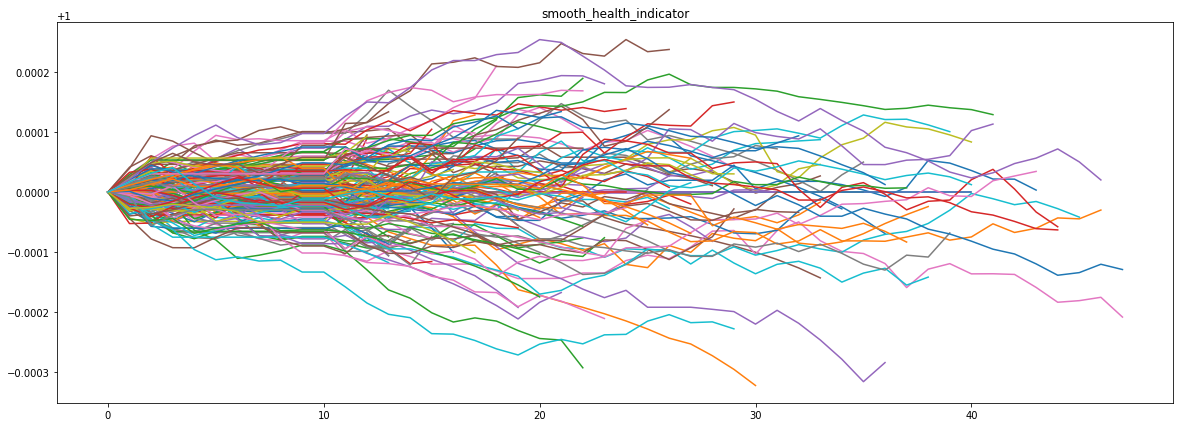

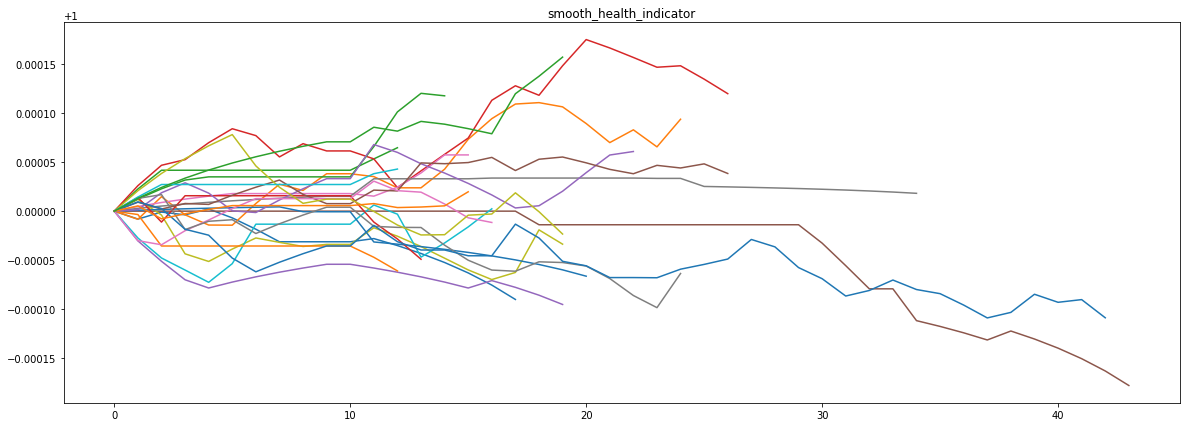

In [23]:
plot_samples(fused_data, plot_cols=['smooth_health_indicator'], plot_units=200, figsize=(20, 7))
plot_samples(val_fused_data, plot_cols=['smooth_health_indicator'], plot_units=23, figsize=(20, 7))

# Similarity based RUL model

In [24]:
health_indicator = fused_data[['Unit', 'Time', 'smooth_health_indicator']]

reg_model_lib = dict()
degree = 7
for unit in health_indicator['Unit'].unique():
    # get each unit data
    unit_data = health_indicator[health_indicator['Unit'] == unit]
    unit_data.reset_index(drop=True, inplace=True)
    
    # convert to poly feature with degree = 2
    X_poly = unit_data.Time
    y_poly = unit_data['smooth_health_indicator']
    
    poly = PolynomialFeatures(degree=degree)
    X_poly = poly.fit_transform(X_poly.values.reshape(-1, 1))
    
    # fit poly line
    clf = LinearRegression()
    clf.fit(X_poly, y_poly)
    
    # save unit line to query dict
    reg_model_lib[unit] = clf

### Test poly models

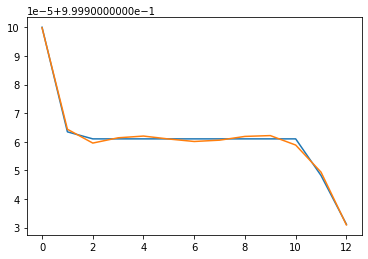

In [25]:
test_unit = 234

model = reg_model_lib[test_unit]

unit_data = health_indicator[health_indicator['Unit'] == test_unit]
unit_data.reset_index(drop=True, inplace=True)

X_poly = unit_data.Time
y_poly = unit_data['smooth_health_indicator']
poly = PolynomialFeatures(degree)
X_poly = poly.fit_transform(X_poly.values.reshape(-1, 1))

plt.plot(y_poly)
plt.plot(model.predict(X_poly))

# Get loss

In [26]:
loss_10, labels_10, pred_10 = predict(health_indicator, val_fused_data, 0, reg_model_lib, break_point=10, NEIGHBORS_NUM=50)
loss_50, labels_50, pred_50 = predict(health_indicator, val_fused_data, 0.5, reg_model_lib, break_point=0, NEIGHBORS_NUM=50)
loss_70, labels_70, pred_70 = predict(health_indicator, val_fused_data, 0.7, reg_model_lib, break_point=0, NEIGHBORS_NUM=50)
loss_90, labels_90, pred_90 = predict(health_indicator, val_fused_data, 0.9, reg_model_lib, break_point=0, NEIGHBORS_NUM=50)

In [27]:
loss_df = pd.DataFrame()
loss_df['True RUL 50'] = labels_50
loss_df['Pred RUL 50'] = pred_50
loss_df['Sample 50%'] = loss_50

loss_df['True RUL 70'] = labels_70
loss_df['Pred RUL 70'] = pred_70
loss_df['Sample 70%'] = loss_70

loss_df['True RUL 90'] = labels_90
loss_df['Pred RUL 90'] = pred_90
loss_df['Sample 90%'] = loss_90

loss_df['True RUL 10'] = labels_10
loss_df['Pred RUL 10'] = pred_10
loss_df['Sample 10'] = loss_10

In [21]:
loss_df

,True RUL 50,Pred RUL 50,Sample 50%,True RUL 70,Pred RUL 70,Sample 70%,True RUL 90,Pred RUL 90,Sample 90%,True RUL 10,Pred RUL 10,Sample 10
0,9,10.143143,1.143143,6,8.980981,2.980981,2,7.897397,5.897397,8,10.028028,2.028028
1,13,7.183684,5.816316,8,8.580080,0.580080,3,6.571572,3.571572,15,8.802803,6.197197
2,7,11.178679,4.178679,4,8.310811,4.310811,2,7.132633,5.132633,3,7.509009,4.509009
3,14,5.272773,8.727227,9,7.402402,1.597598,3,6.114114,3.114114,17,7.509009,9.490991
4,10,9.415415,0.584585,6,8.803303,2.803303,2,7.852352,5.852352,10,9.415415,0.584585
...,...,...,...,...,...,...,...,...,...,...,...,...
57,9,11.415415,2.415415,6,9.504505,3.504505,2,8.792793,6.792793,7,9.891892,2.891892
58,13,8.865866,4.134134,8,7.852352,0.147648,3,6.068569,3.068569,16,9.415415,6.584585
59,7,13.211211,6.211211,4,10.619620,6.619620,2,9.776777,7.776777,3,9.347347,6.347347
60,11,9.347347,1.652653,7,8.803303,1.803303,3,7.852352,4.852352,11,9.347347,1.652653


In [28]:
loss_df

,True RUL 50,Pred RUL 50,Sample 50%,True RUL 70,Pred RUL 70,Sample 70%,True RUL 90,Pred RUL 90,Sample 90%,True RUL 10,Pred RUL 10,Sample 10
0,9,10.143143,1.143143,6,8.980981,2.980981,2,7.897397,5.897397,8,10.028028,2.028028
1,13,7.183684,5.816316,8,8.580080,0.580080,3,6.571572,3.571572,15,8.802803,6.197197
2,7,11.178679,4.178679,4,8.310811,4.310811,2,7.132633,5.132633,3,7.509009,4.509009
3,14,5.272773,8.727227,9,7.402402,1.597598,3,6.114114,3.114114,17,7.509009,9.490991
4,10,9.415415,0.584585,6,8.803303,2.803303,2,7.852352,5.852352,10,9.415415,0.584585
...,...,...,...,...,...,...,...,...,...,...,...,...
57,9,11.415415,2.415415,6,9.504505,3.504505,2,8.792793,6.792793,7,9.891892,2.891892
58,13,8.865866,4.134134,8,7.852352,0.147648,3,6.068569,3.068569,16,9.415415,6.584585
59,7,13.211211,6.211211,4,10.619620,6.619620,2,9.776777,7.776777,3,9.347347,6.347347
60,11,9.347347,1.652653,7,8.803303,1.803303,3,7.852352,4.852352,11,9.347347,1.652653


<AxesSubplot:>

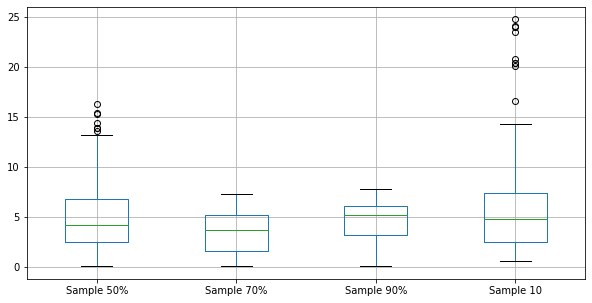

In [29]:
loss_df[['Sample 50%', 'Sample 70%', 'Sample 90%', 'Sample 10']].boxplot(figsize=(10, 5))

In [22]:
loss_df.to_csv('many_sensor_datav3.csv', index=False)

<AxesSubplot:>

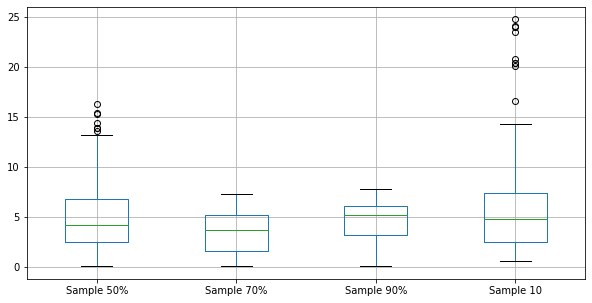

In [23]:
loss_df[['Sample 50%', 'Sample 70%', 'Sample 90%', 'Sample 10']].boxplot(figsize=(10, 5))

<AxesSubplot:>

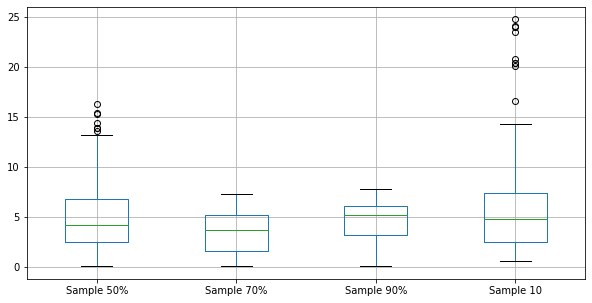

In [24]:
loss_df[['Sample 50%', 'Sample 70%', 'Sample 90%', 'Sample 10']].boxplot(figsize=(10, 5))

In [25]:
display(loss_df[['Sample 50%', 'Sample 70%', 'Sample 90%']].mean())
display(loss_df[['Sample 50%', 'Sample 70%', 'Sample 90%']].std())
display(loss_df[['Sample 50%', 'Sample 70%', 'Sample 90%']].median())

Sample 50%    5.231699
Sample 70%    3.470462
Sample 90%    4.624762
dtype: float64

Sample 50%    4.229049
Sample 70%    2.013313
Sample 90%    2.027251
dtype: float64

Sample 50%    4.160911
Sample 70%    3.617618
Sample 90%    5.137888
dtype: float64

### Visual 1 validation sample

In [26]:
unit_sample = val_fused_data[val_fused_data['Unit'] == 37][['Time', 'smooth_health_indicator']]
len_samples = [0.5, 0.7, 0.9]
true_RUL_point = int(len(unit_sample) * len_samples[1])
true_RUL = len(unit_sample) - true_RUL_point

scores_list = scoring(train_data, unit_sample, reg_model_lib, true_RUL_point)

sorted_scores = dict(sorted(scores_list.items(), key=lambda item: item[1]))
NEIGHBORS_NUM = 50
selected_units = list(sorted_scores.keys())[:NEIGHBORS_NUM] # get nearest neighbors

# plot sample and its neighbors
plot_neighbors(train_data=health_indicator, val_sample=unit_sample.iloc[:true_RUL_point], 
               selected_units=selected_units, figsize=(10, 3))

# plot distribution and predicted RUL
distributions = []
for unit in selected_units:
    neighbor_data = health_indicator[health_indicator['Unit'] == unit]
    neightbor_rul = len(neighbor_data) - true_RUL_point
    if neightbor_rul <= 0:
        continue
    distributions.append(neightbor_rul)

plt.figure()
distributions = pd.Series(np.array(distributions).flatten())
ax = distributions.plot(kind='kde', figsize=(10, 5))

hist_x = ax.lines[0]._x
hist_y = ax.lines[0]._y
density_peak = np.argmax(hist_y)

cdf = scipy.integrate.cumtrapz(hist_y, hist_x, initial=0)
nearest_05 = np.abs(cdf-0.5).argmin()
predict_RUL = hist_x[nearest_05]


plt.plot([true_RUL, true_RUL], [0, hist_y[density_peak]], c='r', label='True RUL')
plt.plot([predict_RUL, predict_RUL], [0, hist_y[density_peak]], c='g', label='Predicted RUL')
plt.title('Distribution and predicted RUL')
plt.legend()

print('Loss: ', predict_RUL - true_RUL)

ValueError: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.

# Live data

In [ ]:
live_val_data = pd.read_csv('../results/rul_data/val_live_data_v3.csv')
# norm data
live_val_fused_data = data_fusion(live_val_data[select_cols_matlab2], reg_model.coef_, 
                                  live_val_data.Unit, live_val_data.Timestep, 20)

In [ ]:
predict, unit = live_predict(train_data, live_val_fused_data, reg_model_lib, polynomial_deg=7, NEIGHBORS_NUM=50)

In [ ]:
# output
result = pd.DataFrame()

# predictions data
live_pred = pd.DataFrame()
live_pred['predict'] = np.round(predict)
live_pred['Unit'] = unit

live_date = live_val_data[['Timestamp', 'set_AssetId', 'Unit']].drop_duplicates(subset=['set_AssetId'], keep='last')
day_count = pd.DataFrame(live_val_data.set_AssetId.value_counts().reset_index())
day_count.columns = ['set_AssetId', 'working_day']

result = live_date.merge(day_count)
result = result.merge(live_pred)

# convert datetime
result['Timestamp'] = pd.to_datetime(result['Timestamp'])
result['Predict_Day'] = 0

for index, row in result.iterrows():
    pred_day = result.iloc[index]['predict']
    result.loc[index, 'Predict_Day'] = (result.iloc[index]['Timestamp'] + pd.DateOffset(days=pred_day)).date()

In [ ]:
START_DATE = datetime.strptime('2022-03-17', "%Y-%m-%d").date()
END_DATE = datetime.strptime('2022-03-24', "%Y-%m-%d").date()
UPPER_PERIODE_LENGTH = 45
LOWER_PERIODE_LENGTH = 14

In [ ]:
sub_result = result[(result['Predict_Day'] >= START_DATE) & (result['Predict_Day'] < END_DATE)]
sub_result = sub_result[(sub_result["working_day"] < UPPER_PERIODE_LENGTH) & 
                        (sub_result["working_day"] > LOWER_PERIODE_LENGTH)]

sub_result = sub_result.reset_index(drop=True)

In [ ]:
sub_result

In [ ]:
result

In [ ]:
import ast
def convert_to_string(x):
    return ast.literal_eval(x)[0]

result['set_AssetId'] = result['set_AssetId'].apply(convert_to_string)

In [ ]:
list_live_asset = ['07f4246e-0000-0000-191c-010000000000','07f4246e-0000-0000-4a19-010000000000',
                   '07f4246e-0000-0000-681b-010000000000', '5c208234-a66f-48ce-a647-b447f522aaa1']

result[result['set_AssetId'].isin(list_live_asset)]